In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    torch.set_default_device('cuda')
else:
    torch.set_default_device('cpu')

x = torch.randn(3, 3)
print(x.device)  # 如果有 GPU，则输出 `cuda:0`

cuda:0


In [2]:
context_length = 16 # 上下文长度
batch_size = 4 # 训练批次
d_model = 64 # 维度
num_blocks = 8 # transformer block的个数
num_heads = 4 # attension head的个数
dropout = 0.1 # dropout概率

### download traing data

In [3]:
import os
import requests

# if sales_textbook.txt not exists, download it
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
text[:100]

'Chapter 1: Building Rapport and Capturing Attention\nSubpoint: Understanding the Importance of Buildi'

### tokenize text

In [5]:
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text=text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long)
max_token_id = tokenized_text.max().item()

### get train_data(x_batch) and val_data(y_batch)

In [6]:
split_idx = int(len(tokenized_text) * 0.8)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

data = train_data
# 随机拿到batch_size个token开始的下标
batch_idx = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
print(batch_idx)

# 从data中取出batch_size个长度为context_length的序列，y_batch是x_batch往后偏移一位
x_batch = torch.stack([data[i:i+context_length] for i in batch_idx])
y_batch = torch.stack([data[i + 1:i+context_length + 1] for i in batch_idx])
print(x_batch.shape, y_batch.shape)

tensor([54696, 16365, 15056, 56785], device='cuda:0')
torch.Size([4, 16]) torch.Size([4, 16])


### initialize token embedding lookup table

In [7]:
# nn.Embedding(num_embeddings, embedding_dim), 第一个参数是可以索引的 token 数量，如果num_embeddings为10，那么索引可以是0-9。所以这里需要+1，这样才能索引到最大的那个token
token_embedding_lookup_table = nn.Embedding(max_token_id + 1, d_model)
print(token_embedding_lookup_table)

x_batch_embedding = token_embedding_lookup_table(x_batch)
y_batch_embedding = token_embedding_lookup_table(y_batch)
print(x_batch_embedding.shape, y_batch_embedding.shape) # [batch_size, context_length, d_model]

Embedding(100070, 64)
torch.Size([4, 16, 64]) torch.Size([4, 16, 64])


### initialize position encoding lookup table

1. 论文中的公式：
$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

$$
PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

2. 取出分母进行转化：
$$
10000^{\frac{2i}{d_{model}}} = e^{\ln(10000^{\frac{2i}{d_{model}}})} = e^{\frac{2i}{d_{model}} \ln(10000)}
$$

3. 所以：
$$
\frac{1}{10000^{\frac{2i}{d_{model}}}} = e^{-\frac{2i}{d_{model}} \ln(10000)}
$$

4. pytorch的代码
```python
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
```

其实计算的就是：
$$
e^{-\frac{2i}{d_{model}} \ln(10000)}
$$

5. position乘以div_term
$$
position \cdot div\_term = pos \cdot e^{-\frac{2i}{d_{model}} \ln(10000)}
$$

$$
pos \cdot e^{-\frac{2i}{d_{model}} \ln(10000)} = e^{\ln(pos)} \cdot e^{-\frac{2i}{d_{model}} \ln(10000)}
$$
$$
= e^{\ln(pos) - \frac{2i}{d_{model}} \ln(10000)}
$$
$$
= e^{\ln\left(\frac{pos}{10000^{2i/d_{model}}}\right)}
$$
$$
= \frac{pos}{10000^{2i/d_{model}}}
$$


In [8]:
import math
# 1. 先初始化position embedding, 和我们的输入需要是一样的维度，这里是[context_length, d_model]
position_encoding_lookup_table = torch.zeros(context_length, d_model)

# 2. 拿到每个token的位置索引，本来`torch.range(0, context_length, dtype=torch.float)`计算出来是[0, 1, 2, ..., context_length]
# unsqueeze(1) 将其形状从 [context_length] 变为 [context_length, 1]，方便后续计算
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
print(position.shape) # [context_length, 1]

# 计算div_term
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
print(div_term.shape) # [d_model / 2]

# 这里做乘法的时候，会自动将 div_term 扩展为 [1, d_model / 2]，然后和 position 相乘
result = torch.sin(position * div_term) # [context_length, 1] * [1, d_model / 2] = [context_length, d_model / 2]
print(result.shape) # [context_length, d_model / 2]

# 偶数位置使用sin，奇数位置使用cos，[:, ]的意思是取所有行的所有列，但是只取偶数列或者奇数列
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)

# from [context_length, d_model] to [1, context_length, d_model]
# dim=0 添加一个维度
unsqueezed_position_encoding_loopup_table = position_encoding_lookup_table.unsqueeze_(0)

# 3. 将position embedding扩展到batch_size维度，from [1, context_length, d_model] to [batch_size, context_length, d_model]
# -1代表这个维度不变，直接复制上去。这里expand的意思是，有 batch_size 个相同的 position_encoding_lookup_table
# expand不会复制数据，不会占用额外的内存，适用于所有 batch 共享相同的位置编码
position_encoding_lookup_table = unsqueezed_position_encoding_loopup_table.expand(batch_size, -1, -1)
position_encoding_lookup_table.shape

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

torch.Size([16, 1])
torch.Size([32])
torch.Size([16, 32])
Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746904,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893435,-0.939824,0.341660,-0.608109,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


### add positional encoding into the input embedding vector

In [9]:
print(x_batch_embedding.shape, position_encoding_lookup_table.shape)

input_embedding_x = x_batch_embedding + position_encoding_lookup_table
print(input_embedding_x.shape) # [batch_size, context_length, d_model]

input_embedding_y = y_batch_embedding + position_encoding_lookup_table
print(input_embedding_y.shape) # [batch_size, context_length, d_model]

torch.Size([4, 16, 64]) torch.Size([4, 16, 64])
torch.Size([4, 16, 64])
torch.Size([4, 16, 64])


### prepare Q K V (and Wq Wk Wv)

In [10]:
# 1. 将输入复制成三份，分别作为query、key、value
X = input_embedding_x
query = key = value = input_embedding_x
query.shape

Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

# 2. 然后将前面的query、key、value分别乘以Wq、Wk、Wv
Q = Wq(query)
K = Wk(key)
V = Wv(value)

print(Q.shape, K.shape, V.shape) # [batch_size, context_length, d_model]

# 3. 将Q K V拆分为多个头
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)
K = K.view(batch_size, -1, num_heads, d_model // num_heads)
V = V.view(batch_size, -1, num_heads, d_model // num_heads)

# 4. 将Q K V的维度调整，使得头数在前面，方便计算
Q = Q.transpose(1, 2) # [batch_size, num_heads, context_length, d_model // num_heads]
K = K.transpose(1, 2) # [batch_size, num_heads, context_length, d_model // num_heads]
V = V.transpose(1, 2) # [batch_size, num_heads, context_length, d_model // num_heads]

print(Q.shape, K.shape, V.shape) # [batch_size, num_heads, context_length, d_model // num_heads]

torch.Size([4, 16, 64]) torch.Size([4, 16, 64]) torch.Size([4, 16, 64])
torch.Size([4, 4, 16, 16]) torch.Size([4, 4, 16, 16]) torch.Size([4, 4, 16, 16])


### calculate attention score

In [11]:
# 1. 计算Q K的点积，拿到每个token对应每个token之间的attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads)
attention_score.shape # [batch_size, num_heads, context_length, context_length]

torch.Size([4, 4, 16, 16])

### apply mask to attention score

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.572370,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,0.482661,0.174689,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.209696,-0.187202,0.314446,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.529376,0.175206,0.481622,1.957890,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,-0.468308,0.487120,-0.236794,0.439496,-0.506689,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.044048,0.301318,-0.196890,0.662887,-0.554646,-0.437422,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-0.351029,-0.111608,0.001486,0.176006,-0.064131,-0.466137,0.019041,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,-0.333537,-0.104656,-0.065879,0.173311,0.034681,0.167485,0.136945,0.361297,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.482600,0.708026,0.430189,0.802517,0.201869,0.727709,0.895357,1.125081,0.359662,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,-0.041244,-0.421733,-0.194670,0.280529,-0.001825,-0.328247,0.243764,0.071730,-0.359558,0.840882,-inf,-inf,-inf,-inf,-inf,-inf


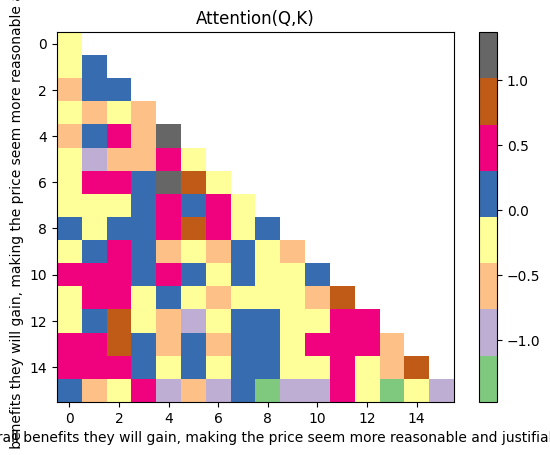

In [12]:
# 把attension score上半个三角矩阵变成-inf，这样softmax之后，这些位置的值就会变成0
# diagonal为是否包含对角线, diagonal为0, 代表包含对角线
mask = torch.triu(torch.ones_like(attention_score, dtype=torch.bool), diagonal=1)

attention_score = attention_score.masked_fill(mask, -float('inf')) # [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

### apply softmax to attention score

In [13]:
attention_score = torch.softmax(attention_score, dim=-1)
# 代表第一个batch的第一个head的维度：
print(attention_score[0][0].shape)
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

torch.Size([16, 16])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.576390,0.423610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.269414,0.275543,0.455043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.146464,0.102782,0.139634,0.611120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.120460,0.313170,0.151841,0.298605,0.115924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.163842,0.211912,0.128761,0.304216,0.090036,0.101234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.110394,0.140257,0.157051,0.186997,0.147077,0.098391,0.159833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.083866,0.105435,0.109604,0.139221,0.121199,0.138412,0.134249,0.168014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.091673,0.114854,0.086992,0.126236,0.069235,0.117137,0.138516,0.174289,0.081069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.088461,0.060466,0.075879,0.122039,0.092018,0.066391,0.117634,0.099042,0.064345,0.213726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### calculate the V attension output

In [14]:
# QK相乘，经过mask+softmax后，最后再乘以V得到A
A = torch.matmul(attention_score, V)

### concatenate attention output

In [15]:
print(A.shape) # [batch_size, num_heads, context_length, d_model // num_heads]
A = A.transpose(1, 2) # [batch_size, context_length, num_heads, d_model // num_heads]
print(A.shape)

# 现在一个multi-head attention的输出是[batch_size, context_length, num_heads, d_model // num_heads]，我们需要将其拼接起来
# 将最后两个维度拼接起来（之前是按照num_heads拆分为了多个头，现在把结果拼接回去）
A = A.reshape(batch_size, -1, d_model)
print(A.shape) # [batch_size, context_length, d_model]

torch.Size([4, 4, 16, 16])
torch.Size([4, 16, 4, 16])
torch.Size([4, 16, 64])


### define output weight matrix

In [16]:
# 最后再经过一个Wo的output权重矩阵乘法，得到最终的输出
Wo = nn.Linear(d_model, d_model)
output = Wo(A)
print(output.shape) # [batch_size, context_length, d_model]

torch.Size([4, 16, 64])


### residual connection

In [17]:
# 然后是经过残差连接
output = output + X

### layer normalization

In [18]:
# 然后经过一个层归一化
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)
output_layernorm.shape

torch.Size([4, 16, 64])

### Define Feed Forward Network

In [19]:
# 然后经过一个Feed Forward network，论文中提到由这由两个线性变换组成，中间有一个 ReLU 激活函数。线性变换的维度是 d_model(512) -> d_ff(2048) -> d_model
ffn = nn.Sequential(
    nn.Linear(in_features=d_model, out_features=d_model * 4),
    nn.ReLU(),
    nn.Linear(in_features=d_model * 4, out_features=d_model),
    nn.Dropout(dropout)
)
output_ffn = ffn(output_layernorm)

### residual connection and layerNorm again

In [20]:
# 经过feed forward network之后，又是残差连接 + 层归一化
output_ffn = output_ffn + output_layernorm
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output_ffn)
print(output.shape)

torch.Size([4, 16, 64])


### apply transformer block num_layers times

In [21]:
# 前面所有的的流程就是一个block, 要循环num_blocks次. 这里省略掉，不循环了

### apply linear layer and softmax to get logits

In [22]:
# 所有的transformer block都完成后，还有一个线性层，将d_model维度的输出转换为vocab_size维度，这样就可以预测下一个token了
logits = nn.Linear(d_model, max_token_id + 1)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.968462,-0.723893,0.179482,0.291880,0.165704,0.024525,-0.524418,-0.767083,-0.294429,-0.990375,...,0.243073,0.199172,-0.036398,-0.651471,-0.595128,0.248775,-0.173202,0.963246,-0.853546,0.428203
1,0.753857,-0.564130,0.474841,0.532484,0.423013,0.921667,-0.417976,-0.660412,0.123473,-0.106250,...,-0.278181,-0.328357,0.100623,-0.788669,0.338388,0.314632,0.795433,0.561310,0.488378,0.300497
2,-0.176075,-0.846429,-0.283244,-0.125530,0.336542,-0.532574,-0.369126,0.771241,-0.493530,0.168694,...,-0.176228,0.031472,-0.062389,-0.609650,-0.189824,0.936057,-0.548682,-0.750560,-0.470630,0.922288
3,-0.837046,-0.374642,-0.179053,-0.003158,0.790854,0.418094,-0.027919,0.265052,-0.121279,0.460344,...,0.231743,-0.618006,-0.458382,-0.771159,0.396708,0.530117,0.143201,0.188614,0.037991,0.753408
4,0.122729,-1.103710,-0.775279,0.536631,0.785496,0.387214,-0.007579,-0.423091,0.307288,0.326950,...,-1.455806,-0.527536,-0.241433,-0.912751,-0.792302,0.703048,0.442174,0.009555,0.317415,0.229154
5,-0.316032,0.049067,-0.352763,0.408319,0.104207,0.182061,0.373167,-0.339175,-0.094519,0.017348,...,-1.610084,0.189311,0.539524,-0.003684,0.337769,0.274788,-0.376054,0.079893,-0.040008,-0.083442
6,-0.150106,-0.245944,-0.320668,0.738975,0.380233,-0.297746,0.123625,-0.566797,0.978541,0.218128,...,-0.185741,-0.780843,-0.760362,-0.938323,-1.080620,-0.045552,-0.430606,0.027073,0.228245,1.352099
7,0.115555,0.060275,-0.384909,0.148956,-0.636944,0.505165,0.513592,-0.547660,1.049590,0.236156,...,-0.274924,-1.212803,0.511480,-0.632196,0.299518,0.195126,-0.706093,-0.625332,0.925671,-0.489648
8,0.741860,-1.056861,0.242556,0.423718,0.167498,0.186230,-0.142288,-0.837701,-0.340825,-0.438332,...,0.257339,0.166936,-0.015693,-0.478513,-0.523995,0.217378,-0.477059,0.847606,-0.493956,0.336219
9,-0.128875,0.268904,-0.412383,-0.171521,0.359769,-0.009900,-0.273751,0.067314,0.536764,-0.454098,...,-0.980351,-1.077911,0.246327,-0.001424,-0.098103,-0.058888,-0.411767,-0.620221,0.633505,-0.001174


### get next token

In [23]:
# 我们把logits转换为概率分布，这样logits[-1]就是预测下一个token的概率分布了，找到最大的那个值，就是预测的token id
probabilities = torch.softmax(logits, dim=-1) # [batch_size, context_length, vocab_size]
print(probabilities.shape)

# 看看第一个batch的token的概率分布
pd.DataFrame(probabilities[0].detach().cpu().numpy())

torch.Size([4, 16, 100070])


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000022,0.000004,0.000010,0.000011,0.000010,0.000009,0.000005,0.000004,0.000006,0.000003,...,0.000011,0.000010,0.000008,0.000004,0.000005,0.000011,0.000007,0.000022,0.000004,0.000013
1,0.000018,0.000005,0.000014,0.000014,0.000013,0.000021,0.000006,0.000004,0.000010,0.000008,...,0.000006,0.000006,0.000009,0.000004,0.000012,0.000012,0.000019,0.000015,0.000014,0.000011
2,0.000007,0.000004,0.000006,0.000007,0.000012,0.000005,0.000006,0.000018,0.000005,0.000010,...,0.000007,0.000009,0.000008,0.000005,0.000007,0.000021,0.000005,0.000004,0.000005,0.000021
3,0.000004,0.000006,0.000007,0.000008,0.000019,0.000013,0.000008,0.000011,0.000007,0.000013,...,0.000011,0.000005,0.000005,0.000004,0.000013,0.000014,0.000010,0.000010,0.000009,0.000018
4,0.000010,0.000003,0.000004,0.000014,0.000018,0.000012,0.000008,0.000006,0.000011,0.000012,...,0.000002,0.000005,0.000007,0.000003,0.000004,0.000017,0.000013,0.000009,0.000012,0.000011
5,0.000006,0.000009,0.000006,0.000013,0.000009,0.000010,0.000012,0.000006,0.000008,0.000009,...,0.000002,0.000010,0.000014,0.000008,0.000012,0.000011,0.000006,0.000009,0.000008,0.000008
6,0.000007,0.000007,0.000006,0.000018,0.000012,0.000006,0.000010,0.000005,0.000022,0.000011,...,0.000007,0.000004,0.000004,0.000003,0.000003,0.000008,0.000005,0.000009,0.000011,0.000033
7,0.000009,0.000009,0.000006,0.000010,0.000004,0.000014,0.000014,0.000005,0.000024,0.000011,...,0.000006,0.000003,0.000014,0.000004,0.000011,0.000010,0.000004,0.000005,0.000021,0.000005
8,0.000018,0.000003,0.000011,0.000013,0.000010,0.000010,0.000007,0.000004,0.000006,0.000005,...,0.000011,0.000010,0.000008,0.000005,0.000005,0.000011,0.000005,0.000020,0.000005,0.000012
9,0.000007,0.000011,0.000006,0.000007,0.000012,0.000008,0.000006,0.000009,0.000014,0.000005,...,0.000003,0.000003,0.000011,0.000008,0.000008,0.000008,0.000006,0.000005,0.000016,0.000008


In [24]:
# 第一个batch的输入是：
print(encoding.decode(x_batch[0].tolist()))

# 直接使用argmax来找到概率值最大的token下标
predicted_index = torch.argmax(logits[0, -1]).item()
# 预测出来的token是：
encoding.decode([predicted_index])

 the overall benefits they will gain, making the price seem more reasonable and justifiable


' Assets'

### reference
参考 LLM张老师仓库: https://github.com/waylandzhang/Transformer-from-scratch